In [1]:
# 初始化
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.6 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
# 从kaggle下载数据集
creds = '{"username":"xxkisalovexx", "key":"ae25663747e63cc2e3cdbcd51c7b8289"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/root/.fastai/archive/bluebook-for-bulldozers')

In [5]:
Path.BASE_PATH = path

In [6]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

100%|██████████| 48.4M/48.4M [00:01<00:00, 49.1MB/s]


(#7) [Path('ValidSolution.csv'),Path('TrainAndValid.csv'),Path('Test.csv'),Path('random_forest_benchmark_test.csv'),Path('median_benchmark.csv'),Path('Valid.csv'),Path('Machine_Appendix.csv')]

In [7]:
# 查看数据
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [8]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [9]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [10]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [11]:
# 将ProductSize排序['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

<ipython-input-11-a4b70fad10d2>:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


In [12]:
# 将价格取log
dep_var = 'SalePrice'

In [13]:
df[dep_var] = np.log(df[dep_var])

In [14]:
# 处理日期 将一列日期转换为->年, 月, 日, ...多列
df = add_datepart(df, 'saledate')

In [15]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [16]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [17]:
# 使用TabularPandas和TabularProc进行数据清理
# 包含两个处理步骤, 分类编码和缺失值填充
procs = [Categorify, FillMissing]

In [18]:
# 划分训练集和验证集
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [19]:
# 需要告诉 TabularPandas 哪些列是连续的, 哪些是分类的.
# 我们可以使用辅助函数 cont_cat_split 来自动处理这个问题
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [20]:
cont

['SalesID',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'saleYear',
 'saleMonth',
 'saleWeek',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleElapsed']

In [21]:
cat

['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start']

In [22]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [23]:
len(to.train),len(to.valid)

(404710, 7988)

In [24]:
to.show(3)

In [25]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

In [26]:
to.items.head(3)

SalesID  SalePrice  MachineID  ModelID  ...  saleIs_year_start  \
0  1139246  11.097410     999089     3157  ...                  1   
1  1139248  10.950807     117657       77  ...                  1   
2  1139249   9.210340     434808     7009  ...                  1   

    saleElapsed  auctioneerID_na  MachineHoursCurrentMeter_na  
0  1.163635e+09                1                            1  
1  1.080259e+09                1                            1  
2  1.077754e+09                1                            1  

[3 rows x 67 columns]

In [27]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

state  ProductGroup  Drive_System  Enclosure
0      1             6             0          3
1     33             6             0          3
2     32             3             0          6

In [28]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [29]:
save_pickle(path/'to.pkl',to)

In [30]:
# 创建决策树
to = load_pickle(path/'to.pkl')

In [31]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [32]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

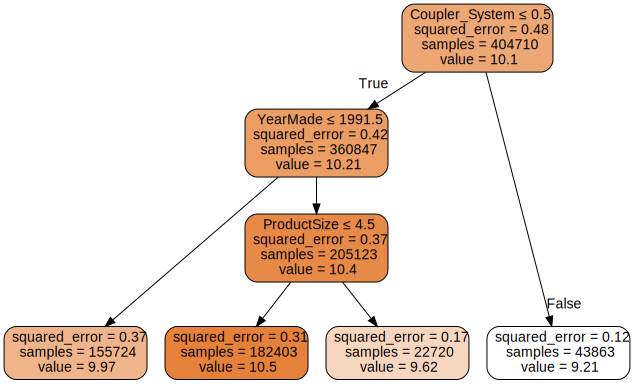

In [33]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [34]:
import sys
import os

%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg'
%matplotlib inline

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import dtreeviz


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


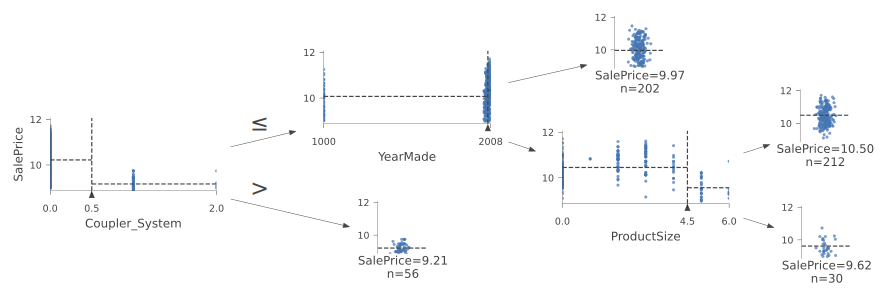

In [35]:
samp_idx = np.random.permutation(len(y))[:500]

viz_model=dtreeviz.model(m,
                         X_train=xs.iloc[samp_idx],
                         y_train=y.iloc[samp_idx],
                         feature_names=xs.columns,
                         target_name=dep_var)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')

# samp_idx = np.random.permutation(len(y))[:500]
# dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
#         fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
#         orientation='LR')

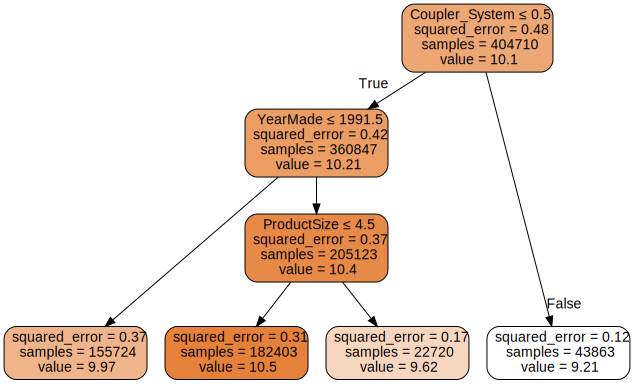

In [36]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


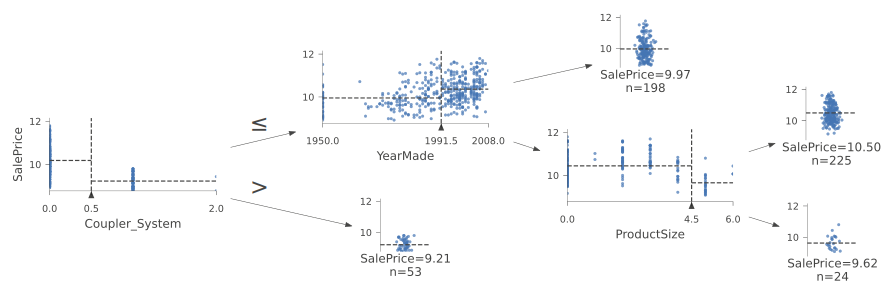

In [37]:
samp_idx = np.random.permutation(len(y))[:500]

viz_model=dtreeviz.model(m,
                         X_train=xs.iloc[samp_idx],
                         y_train=y.iloc[samp_idx],
                         feature_names=xs.columns,
                         target_name=dep_var)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')

In [38]:
# 取消max_leaf_nodes的限制, fit一个更大的树
m = DecisionTreeRegressor()
m.fit(xs, y);

In [39]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [40]:
m_rmse(m, xs, y)

0.0

In [41]:
# 均方根误差
m_rmse(m, valid_xs, valid_y)

0.334828

In [42]:
m.get_n_leaves(), len(xs) # 叶节点数几乎和数据点一样多, 可能过拟合

(324575, 404710)

In [43]:
# 告诉sklearn确保每个叶节点至少包含25条拍卖记录
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y) # 从验证集均方根误差来看没什么变化, 记住有这种方法就行

(0.248563, 0.323365)

In [44]:
m.get_n_leaves() # 叶子数量倒是少了不少

12397

In [45]:
# 随机森林
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [46]:
m = rf(xs, y);

In [47]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y) # 6

(0.171131, 0.232798)

In [48]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X 

In [49]:
r_mse(preds.mean(0), valid_y)

0.232798

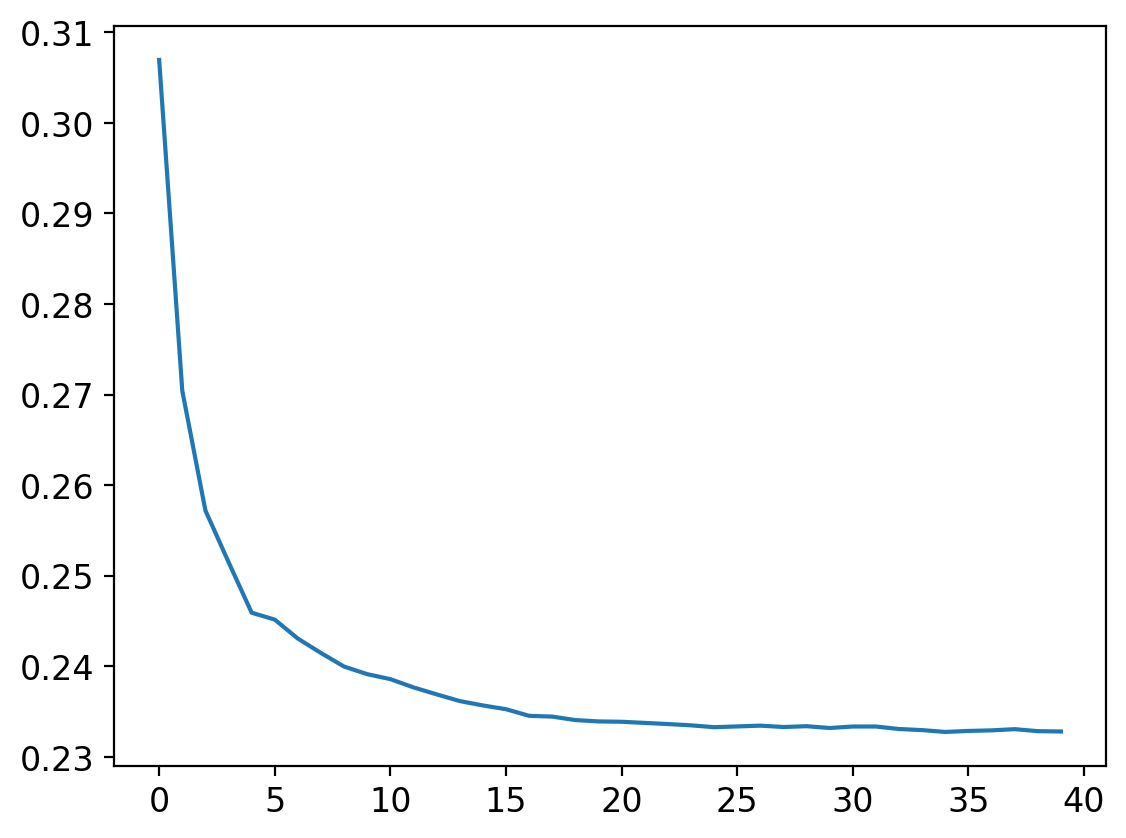

In [50]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [51]:
# 袋外误差
r_mse(m.oob_prediction_, y)

0.210939

In [52]:
# 预测置信度的树方差
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X 

In [53]:
preds.shape

(40, 7988)

In [54]:
preds_std = preds.std(0)

In [55]:
preds_std[:5]

array([0.29284004, 0.14452593, 0.1000865 , 0.2326239 , 0.1348687 ])

In [57]:
# 特征重要性
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [58]:
fi = rf_feat_importance(m, xs)
fi[:10]

cols       imp
57            YearMade  0.181695
6          ProductSize  0.127156
30      Coupler_System  0.112322
7   fiProductClassDesc  0.071572
31      Grouser_Tracks  0.056575
54             ModelID  0.054305
65         saleElapsed  0.049643
3      fiSecondaryDesc  0.041431
32     Hydraulics_Flow  0.037350
1          fiModelDesc  0.030163

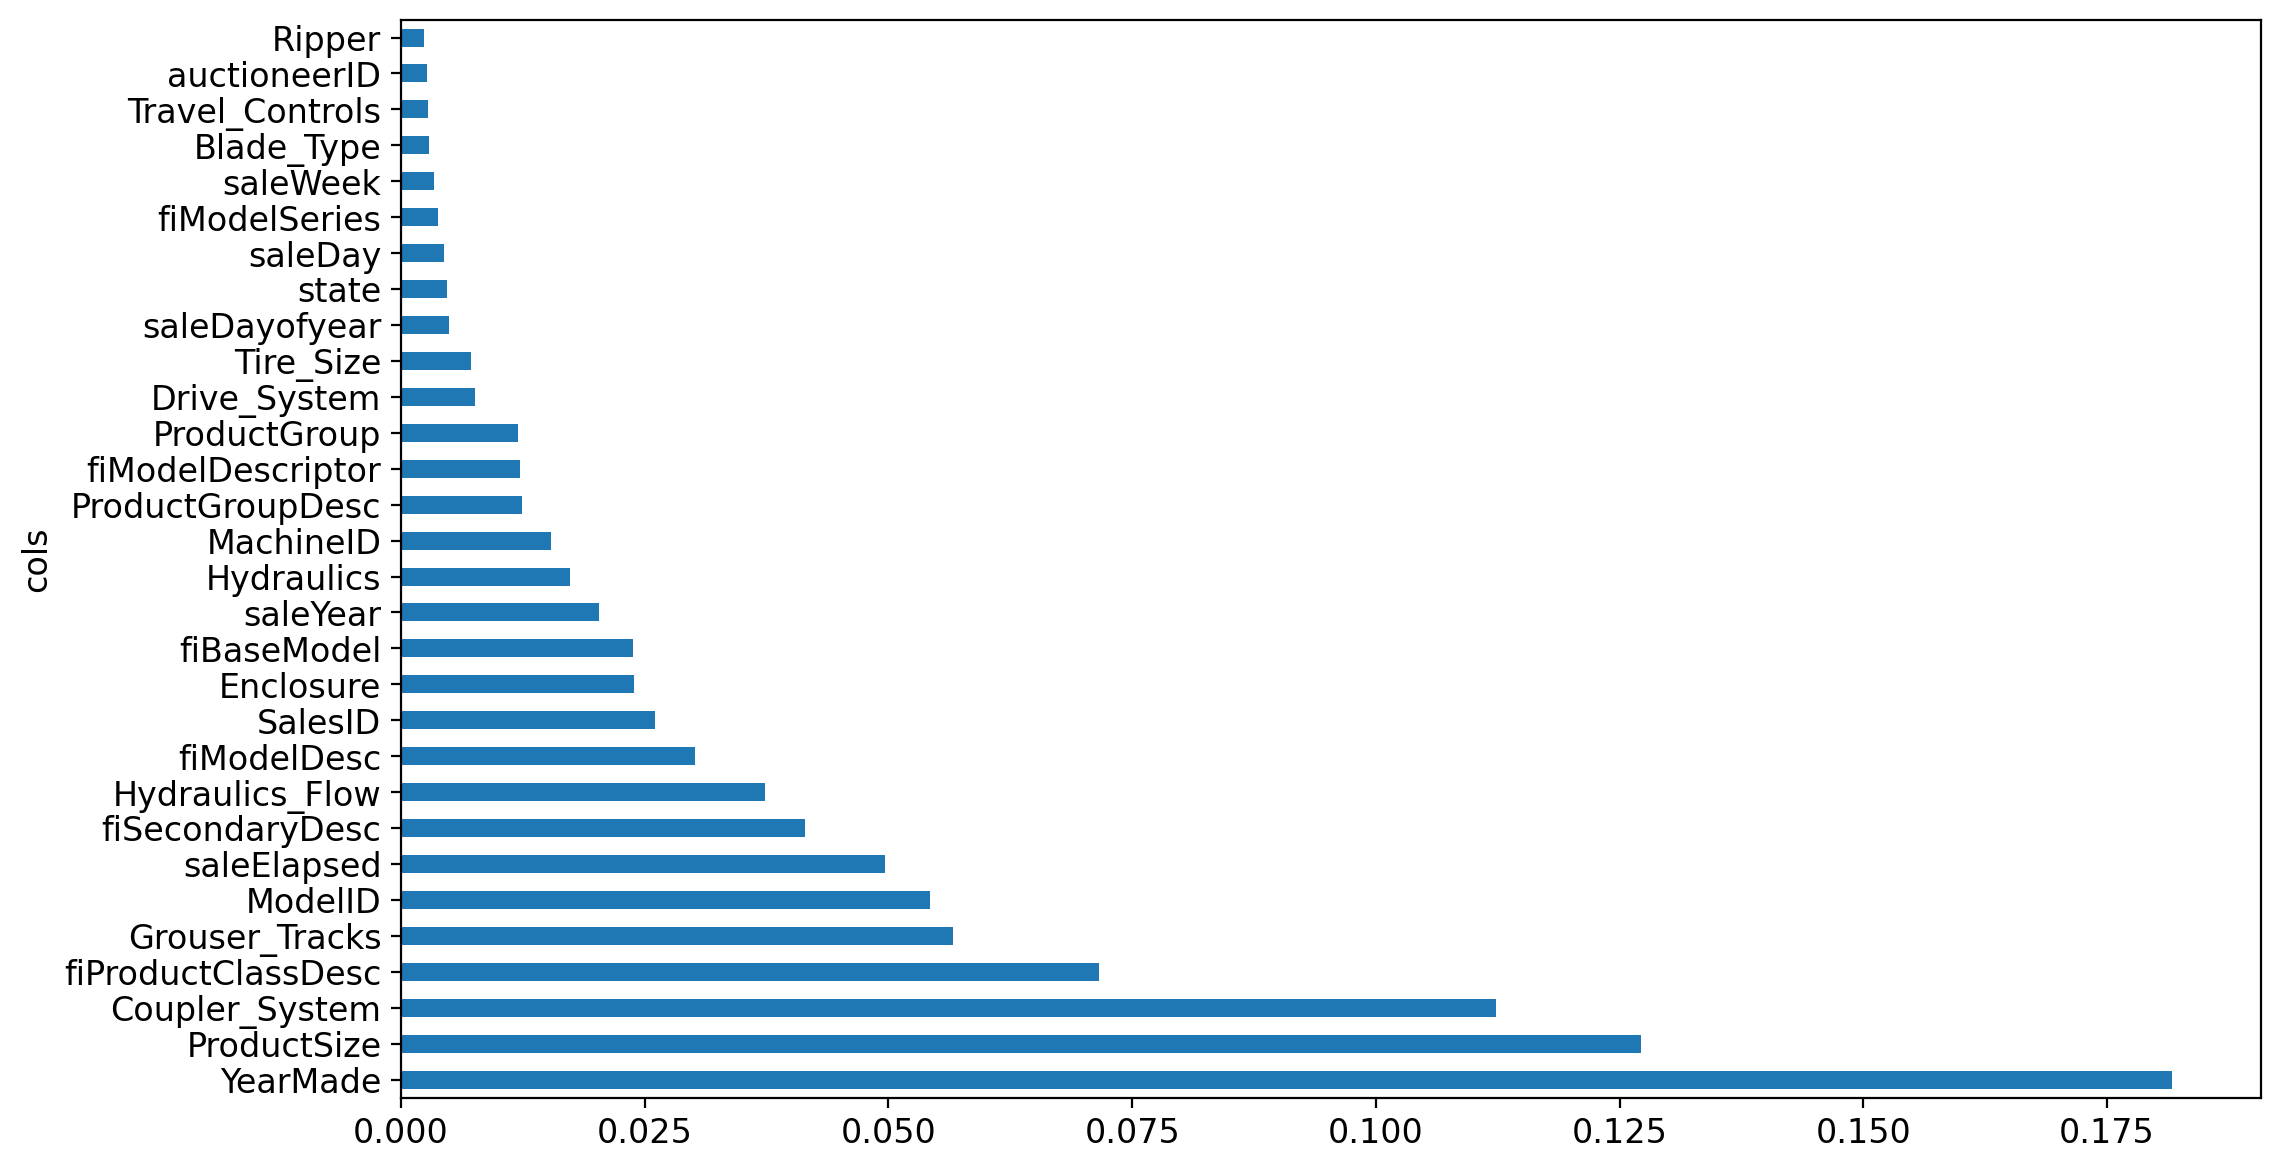

In [59]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [60]:
# 去除低重要性变量
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [61]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [62]:
m = rf(xs_imp, y)

In [63]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181445, 0.230888)

In [64]:
# 准确度大致相同，但我们需要研究的列要少得多
len(xs.columns), len(xs_imp.columns)

(66, 21)

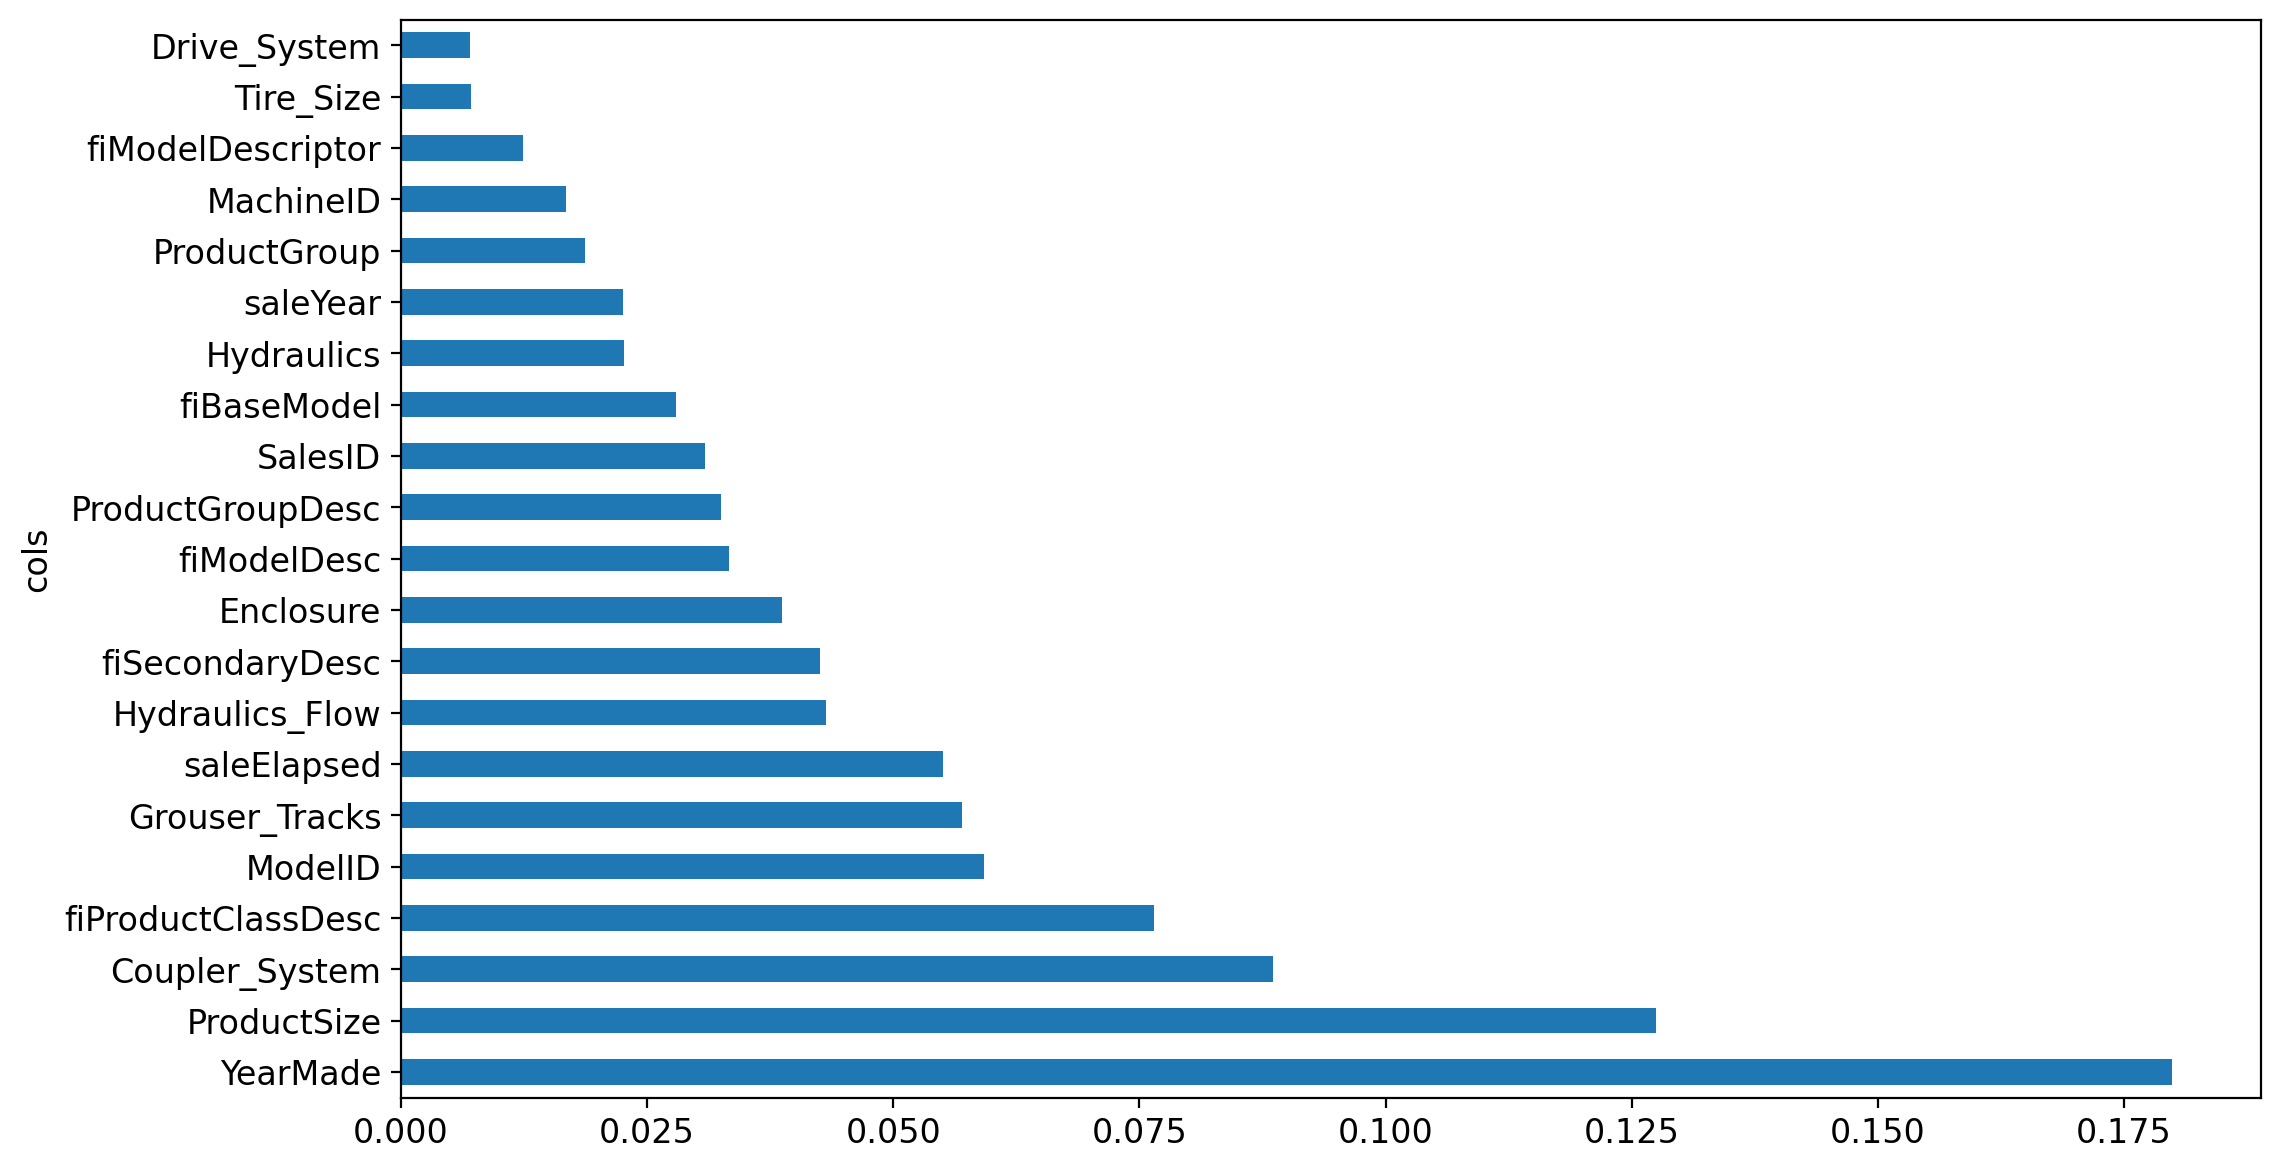

In [65]:
plot_fi(rf_feat_importance(m, xs_imp));

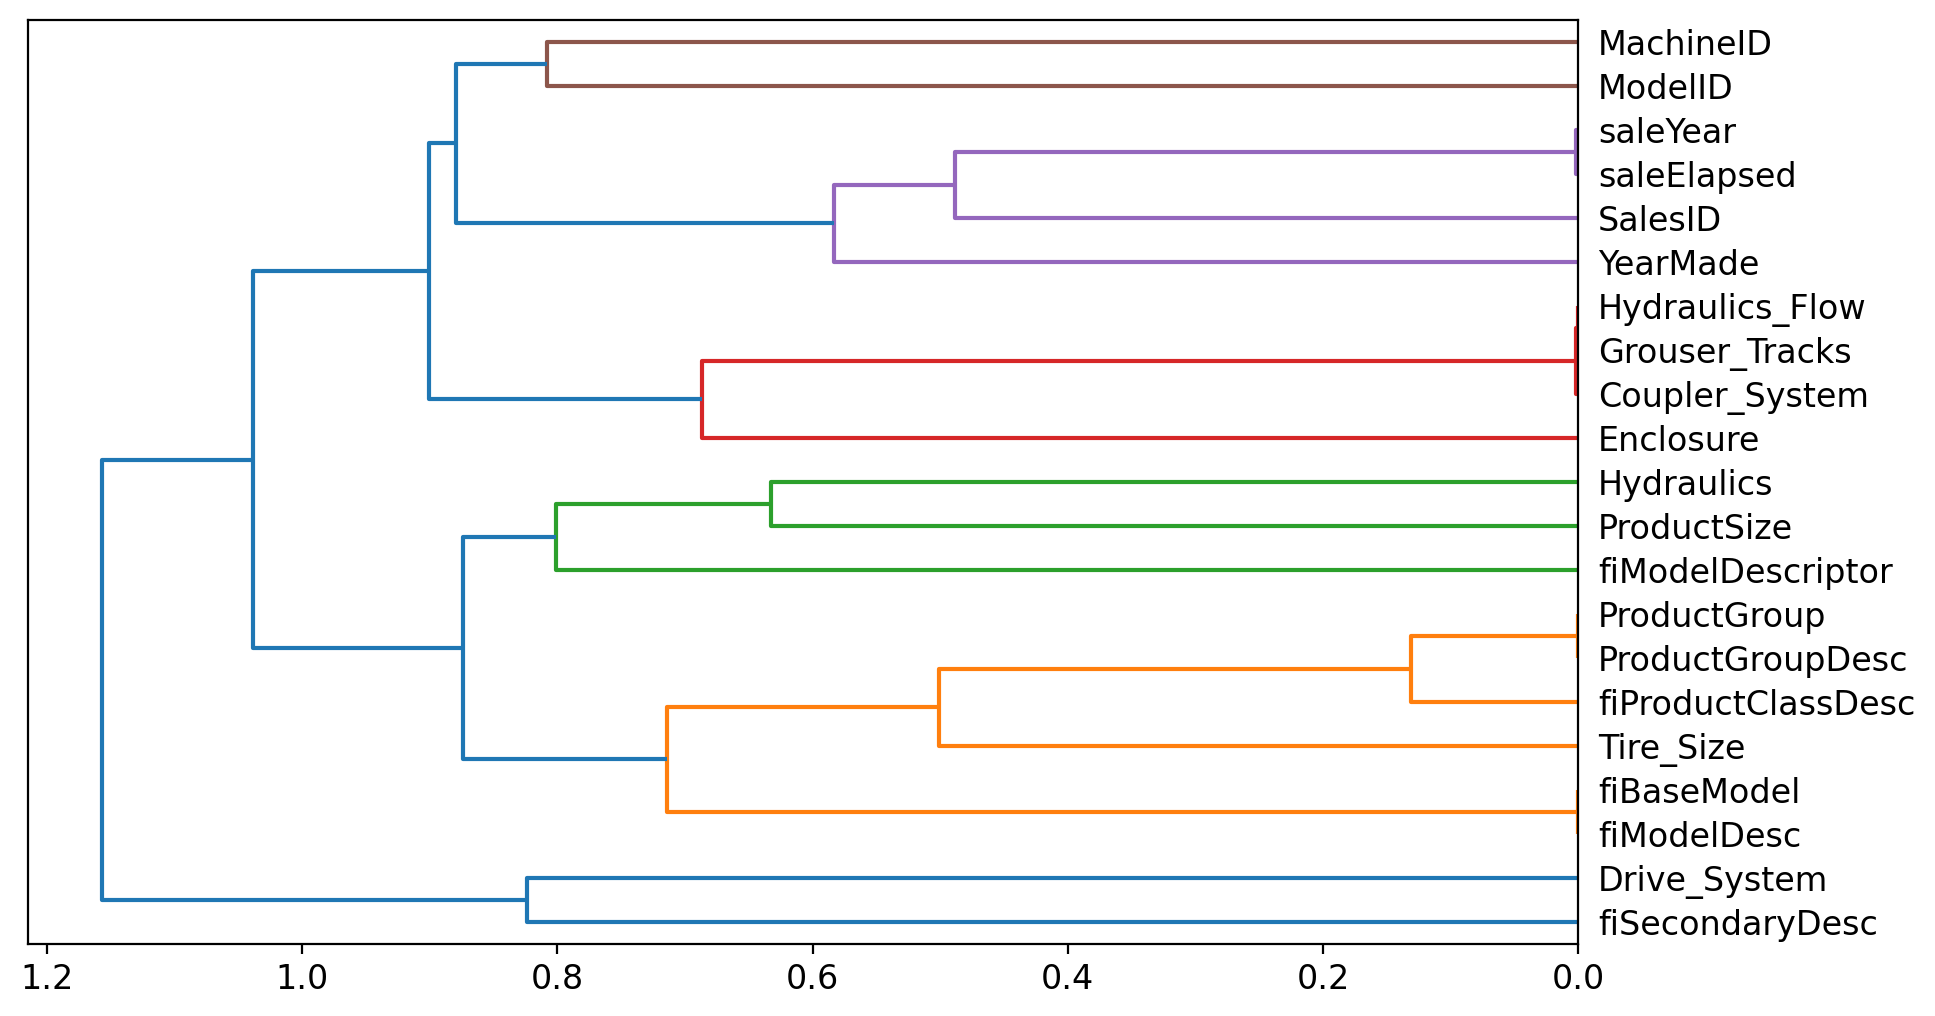

In [66]:
# 去除冗余特征
cluster_columns(xs_imp)

In [67]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [68]:
get_oob(xs_imp)

0.8770244406852692

In [69]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.87572114827891,
 'saleElapsed': 0.8725358121613634,
 'ProductGroupDesc': 0.8773445262798308,
 'ProductGroup': 0.8769750870618541,
 'fiModelDesc': 0.876341927017595,
 'fiBaseModel': 0.8758066427187969,
 'Hydraulics_Flow': 0.8773084385799244,
 'Grouser_Tracks': 0.8772453050452245,
 'Coupler_System': 0.8779665748884293}

In [70]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8743162045835808

In [71]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [72]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [73]:
# 数据集保存加载点
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [74]:
# 确认准确性没有发生实质性变化
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183358, 0.23322)

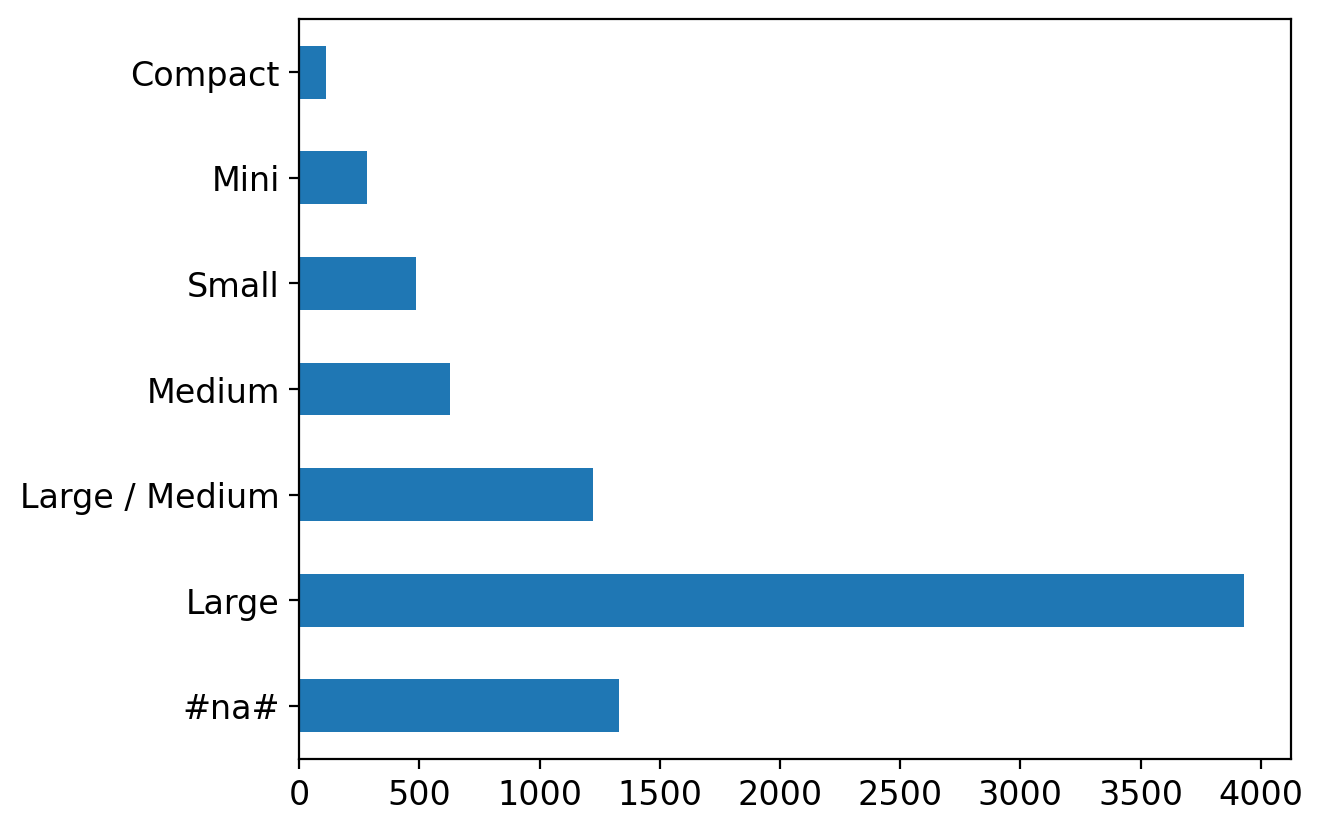

In [75]:
# 部分依赖
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

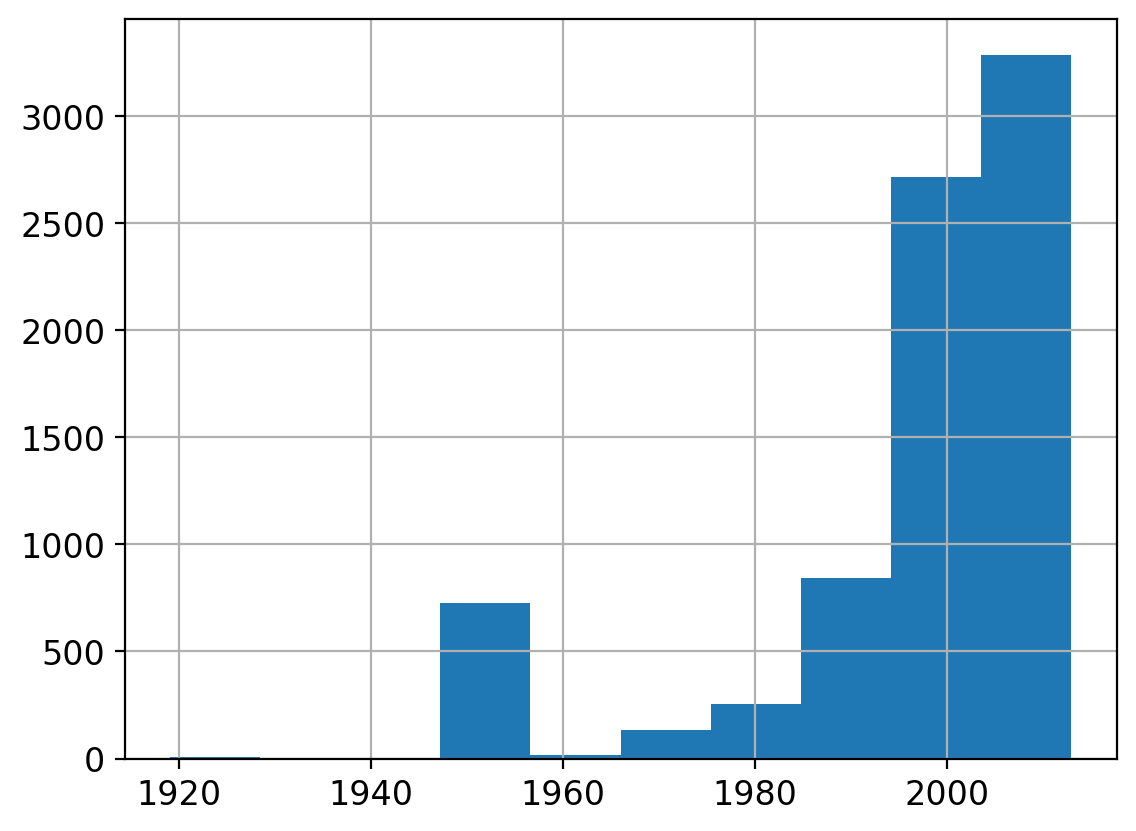

In [76]:
ax = valid_xs_final['YearMade'].hist()

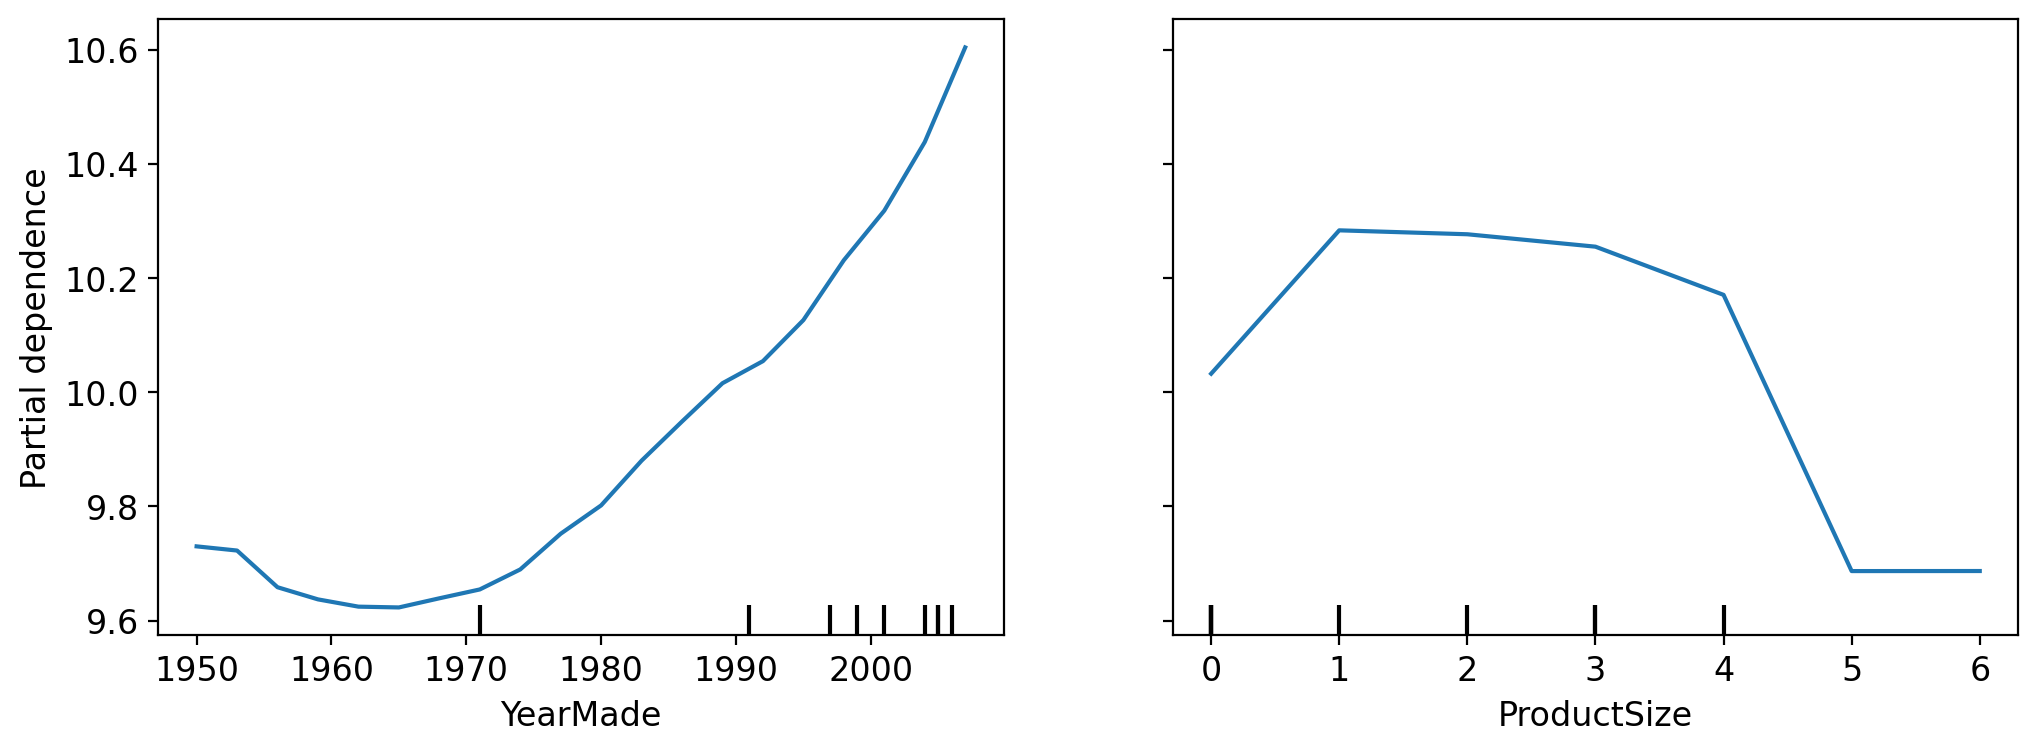

In [78]:
# 如果一行数据除了感兴趣的特征之外没有变化，那么它会如何影响因变量？
from sklearn.inspection import PartialDependenceDisplay
fig,ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['YearMade','ProductSize'], grid_resolution=20, ax=ax)

# from sklearn.inspection import plot_partial_dependence

# fig,ax = plt.subplots(figsize=(12, 4))
# plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
#                         grid_resolution=20, ax=ax);

In [79]:
# 对于预测特定数据行，最重要的因素是什么，它们是如何影响该预测的？
# 用瀑布图展示贡献是最清晰的方式。
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [80]:
row = valid_xs_final.iloc[:5]

In [81]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [82]:
prediction[0], bias[0], contributions[0].sum()

(array([9.94980034]), 10.104301266045688, -0.15450092852437286)

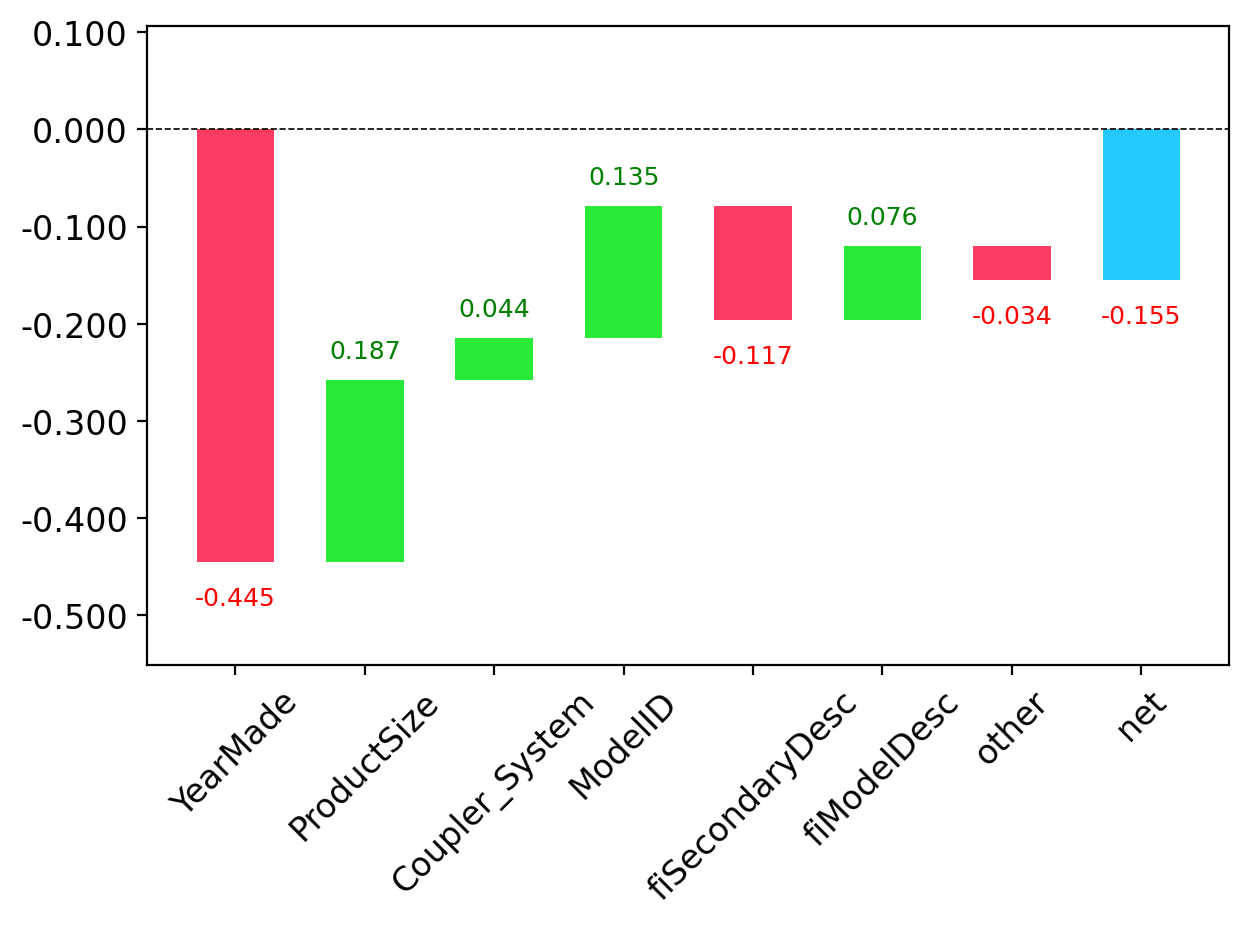

In [83]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08,
          rotation_value=45,formatting='{:,.3f}');

In [84]:
# 外推问题
np.random.seed(42)

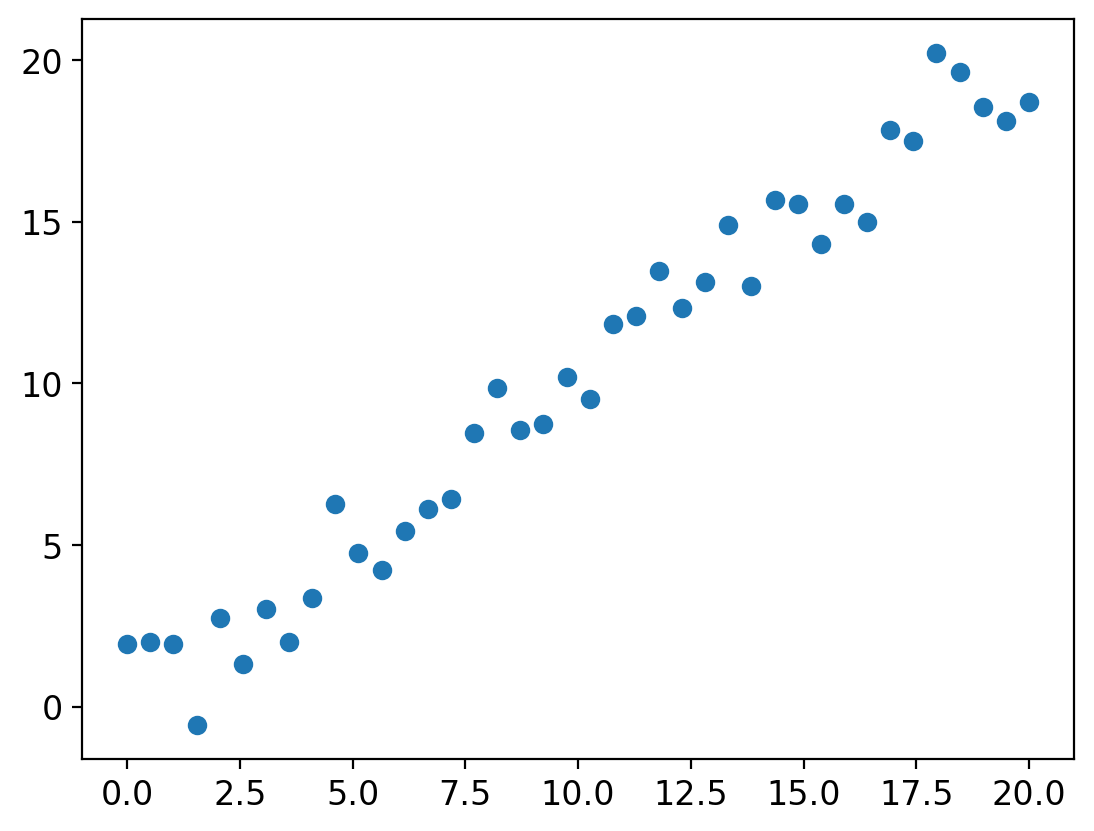

In [85]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [86]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [87]:
x_lin[:,None].shape

torch.Size([40, 1])

In [88]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

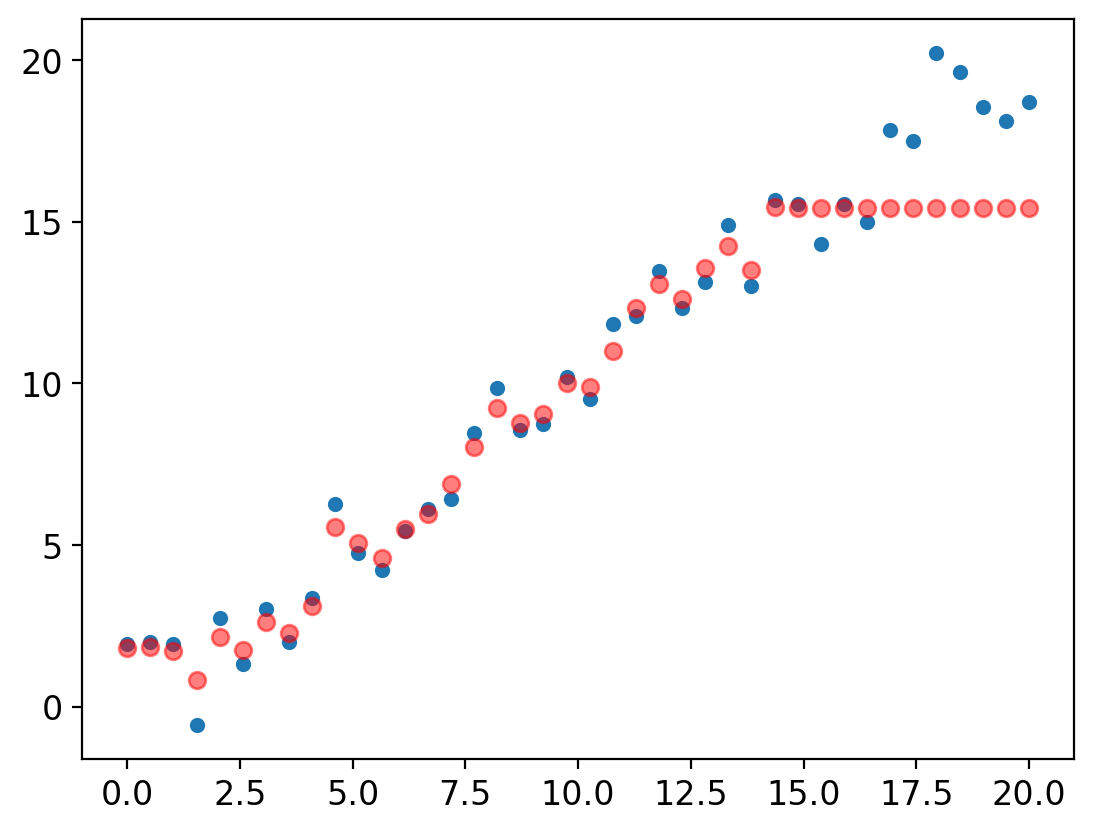

In [89]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

In [90]:
# 寻找领域外数据
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

cols       imp
5   saleElapsed  0.860059
9       SalesID  0.119734
12    MachineID  0.013674
0      YearMade  0.002506
4       ModelID  0.000724
11   Hydraulics  0.000636

In [91]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.232622
SalesID 0.229965
saleElapsed 0.235928
MachineID 0.231637


In [92]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.22918

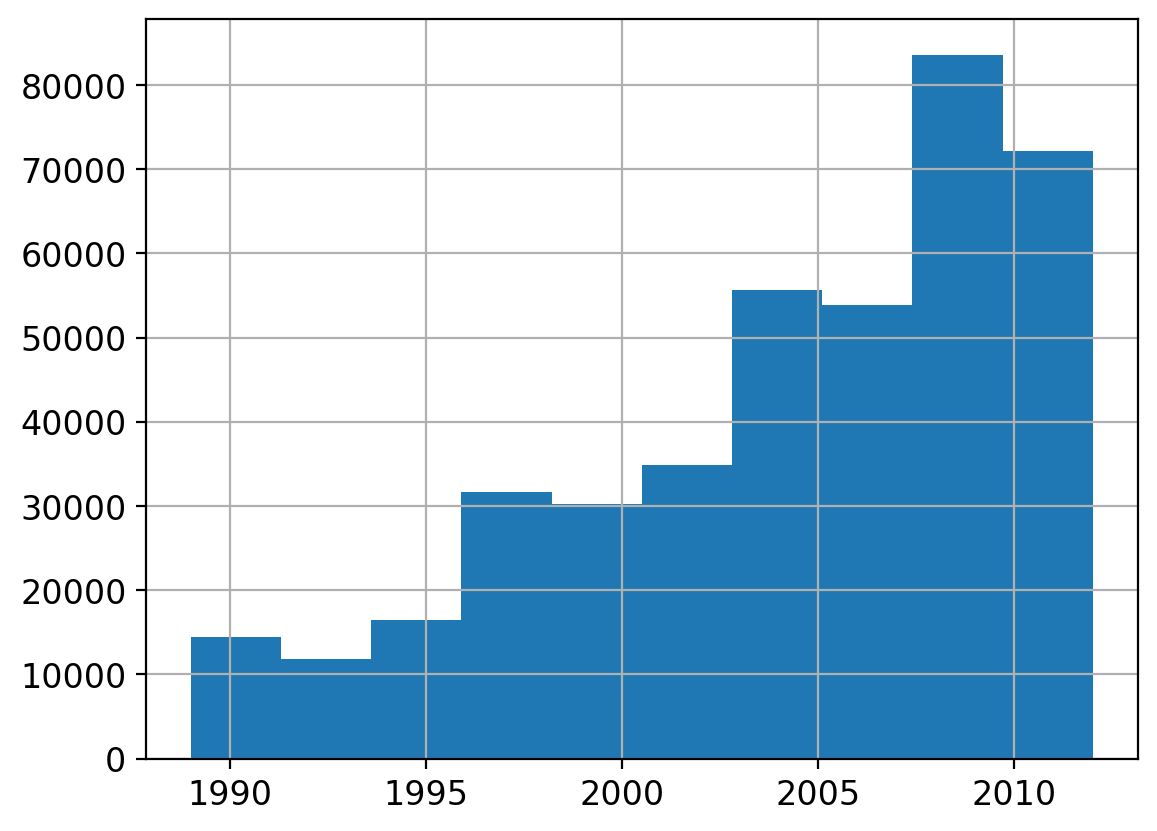

In [93]:
xs['saleYear'].hist();

In [94]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [95]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177538, 0.228276)

In [96]:
# 使用神经网络
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [97]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [98]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [99]:
cont_nn

['saleElapsed']

In [100]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Hydraulics_Flow          3
fiModelDesc           5059
Enclosure                6
Hydraulics              12
fiModelDescriptor      140
ProductGroup             6
Drive_System             4
Tire_Size               17
dtype: int64

In [101]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176964, 0.230416)

In [102]:
cat_nn.remove('fiModelDescriptor')

In [103]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [104]:
dls = to_nn.dataloaders(1024)

In [105]:
y = to_nn.train.y
y.min(),y.max()

(8.465899, 11.863583)

In [106]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0002754228771664202)

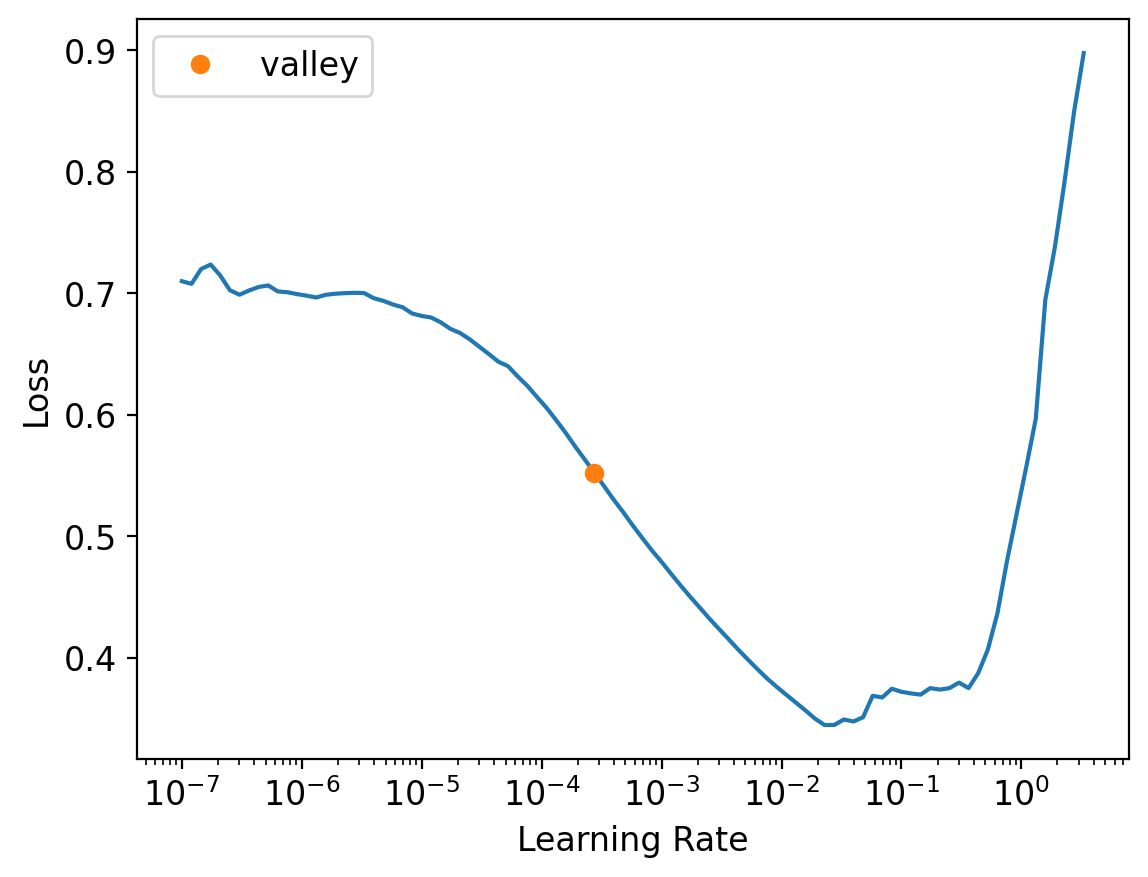

In [107]:
learn.lr_find()

In [108]:
learn.fit_one_cycle(5, 1e-2)

In [109]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.223803

In [110]:
learn.save('nn')

Path('models/nn.pth')

In [112]:
# 随机森林和神经网络的集成模型
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [113]:
r_mse(ens_preds,valid_y)

0.221132